In [1]:
%pylab inline
import torch.nn as nn
import torch
import numpy as np
from tqdm import trange
#torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/leonardo/anaconda3/envs/torch2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  print(fp)
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

/tmp/23278f029ff68f1e993776e500ce06b9
/tmp/d8b415e67abd11881e156b8f111d3300
/tmp/b0cdab8e37ae7c1c5560ee858afaac1d
/tmp/d4fdde61aca9f72d5fe2315410bb46a5


In [3]:
import torch.nn as nn
import torch.nn.functional as F
class BobNet(torch.nn.Module):
    def __init__(self) -> None:
        super(BobNet, self).__init__()
        self.l1 = nn.Linear(784, 128, bias=False)
        self.l2 = nn.Linear(128, 10, bias=False)
        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = self.sm(x)
        return x


loss 0.24 accuracy 0.95: 100%|██████████| 1000/1000 [00:02<00:00, 423.82it/s]


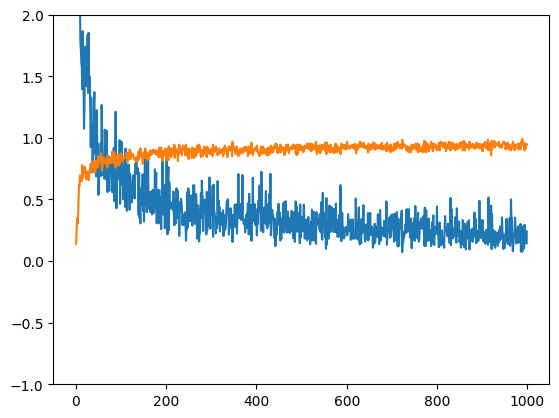

In [4]:
BS = 128

model = BobNet()
loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0)
losses, accuracies = [], []
for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=BS)
    X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[samp]).long()
    model.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-1, 2)
plot(losses)
plot(accuracies)

In [5]:
#evaluation
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.9264

(tensor([1.]), tensor([[ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]))

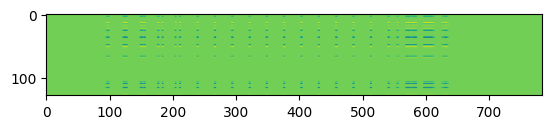

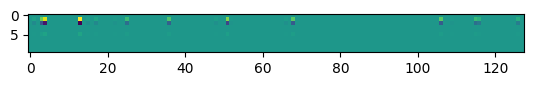

In [6]:
#understand gradients
model.zero_grad()
out = model(torch.tensor(X_test[1:2].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_function(out, torch.tensor(Y_test[1:2]).long())
loss.retain_grad()
loss.backward()
imshow(model.l1.weight.grad)
figure()
imshow(model.l2.weight.grad)
loss.grad, out.grad

In [7]:
#init the network

l1 = np.zeros((784, 128), dtype=np.float32)
l2 = np.zeros((128, 10), dtype=np.float32)

l1 = model.l1.weight.detach().numpy().transpose()
l2 = model.l2.weight.detach().numpy().transpose()

In [8]:
#numpy forward pass

def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)
    return x
Y_test_preds_out = forward(X_test.reshape((-1, 28 * 28)))
Y_test_preds = np.argmax(Y_test_preds_out, axis=1)

In [9]:

def logsumexp(x):
    c=x.max(axis=1)
    return c + np.log(np.exp(x-c.reshape((-1,1))).sum(axis=1))

#still to be understood

def forward_backward(x, y):
    out = np.zeros((len(x),10), np.float32)
    out[range(out.shape[0]),y] = 1

    #forward pass

    x_l1 = x.dot(l1)
    x_relu = np.maximum(x_l1, 0)
    x_l2 = x_relu.dot(l2)
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1,1))
    x_loss =(-out * x_lsm).mean(axis=1)


    #backward pass  hard as fuck!!
    d_out = -out/len(y)

    dx_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1,1))

    #derivative of l2
    d_l2 = x_relu.T.dot(dx_lsm)
    dx_relu = dx_lsm.dot(l2.T)

    #derivative of relu

    dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

    #derivative of l1
    d_l1 = x.T.dot(dx_l1)

    # imshow(d_l1.T)
    # figure()
    # imshow(d_l2.T)

    return x_loss, x_l2, d_l1, d_l2

samp = [1,2]
x_loss, x_l2, dl1, dl2 = forward_backward(X_test[samp].reshape((-1, 28*28)), Y_test[samp])


100%|██████████| 1000/1000 [00:01<00:00, 530.31it/s]


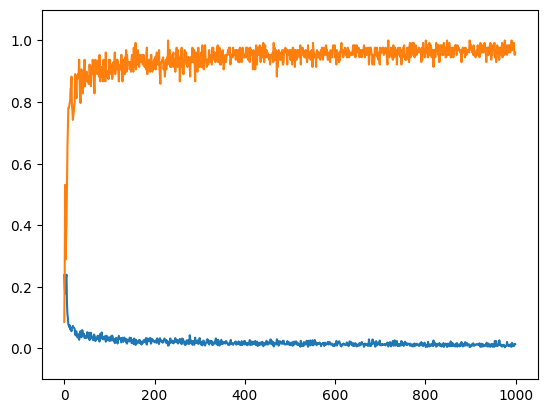

In [10]:
def layer_init(m, h):
  # gaussian is strong
  #ret = np.random.randn(m,h)/np.sqrt(m*h)
  # uniform is stronger
  ret = np.random.uniform(-1., 1., size=(m,h))/np.sqrt(m*h)
  return ret.astype(np.float32)
#reinit
l1 = layer_init(784, 128)
l2 = layer_init(128, 10)

BS = 128
lr = 0.001
losses, accuracies = [], []
for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=BS)
    X = X_train[samp].reshape((-1, 28*28))
    Y = Y_train[samp]
    x_loss, x_l2, d_l1, d_l2 = forward_backward(X, Y)

    cat = np.argmax(x_l2, axis=1)
    accuracy = (cat == Y).mean()


    # SGD
    l1 = l1 - lr*d_l1
    l2 = l2 - lr*d_l2

    loss = x_loss.mean()
    losses.append(loss)
    accuracies.append(accuracy)

    # t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [11]:
def numpy_eval():
  Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
  Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
  return (Y_test == Y_test_preds).mean()
numpy_eval()

0.963

7


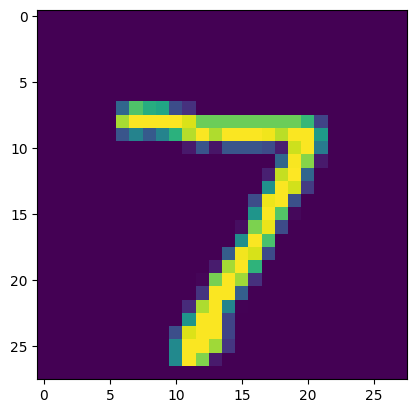

In [12]:
#test with new image from internet

import cv2

img = X_test[0]
print(Y_test[0])
imshow(img)


In [15]:
# what is it?
x = img.reshape(1, -1).dot(l1)
x = np.maximum(x, 0)
x = x.dot(l2)
print("Eu diria que é um ", np.argmax(x))

#agora com torch

Eu diria que é um  7


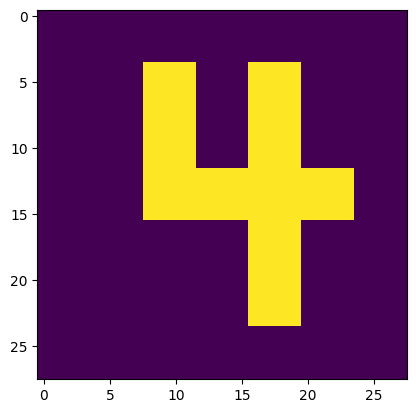

In [14]:
# upscale to 28x28
m = [[0,0,0,0,0,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,1,1,1,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,0,0,0]]
m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
imshow(m.reshape(28,28))

In [16]:
x = m.reshape(1, -1).dot(l1)
x = np.maximum(x, 0)
x = x.dot(l2)
np.argmax(x)

4